# BASEP Current Density Analysis



In this script we are going to analyze the particles current density in the ring formed by optical tweezers.
In this case, unlike previous analysis, we find more than one particle in the ring so we are going to load several tracking files, which each file corresponds to different particle densities in the ring.
From each file we are going to determine the particle's current density in the potential landscape and then, plot the current density in front of the particle density.

In this script we are going to work in a different way than in the previous ones. As it is difficult to load all the tracking files in a single DataFrame, we are going to define some functions to call them in a for loop and, hence, load sequentialy all the files. The loop will calculate the mean velocity for each particle density and then it will be plotted toghether with the ASEP curve to compare them. 

## Function definition

In [1]:
#Imports
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import scipy.optimize as spo

from scipy.interpolate import make_interp_spline, BSpline

idx = pd.IndexSlice
%matplotlib inline

from tqdm import tqdm_notebook

In [2]:
def trackingLoading(filePath):
    t = pd.read_csv(filePath ,sep = "\t", index_col=0)
    t = t.filter(["x","y","frame", "particle"])
    return t

In [3]:
def tmstmpLoading(filePath):
    timestamp = pd.read_csv(filePath, sep="\r", header = None,names=["time"])

    #Calculation of timestamps in nanoseconds
    timestamp["datetime"] =  pd.to_datetime(timestamp.time+2*3600, unit="s", origin=pd.Timestamp('1904-01-01'))
    timestamp["ellapsed_time"] = (timestamp.datetime-timestamp.datetime[0])
    timestamp["time"] = timestamp.ellapsed_time.dt.total_seconds()
    return timestamp

In [4]:
def get_center(trj):
    
    def calc_R(xc, yc):
        """calculate the distance of each 2D points from the center (xc, yc)"""
        return np.sqrt((trj.x.values-xc)**2 + (trj.y.values-yc)**2)

    def f_2(c):
        """calculate the algebraic distance between the data points and the mean 
        circle centered at c=(xc, yc)"""
        Ri = calc_R(*c)
        return Ri - Ri.mean()    

    center_estimate = 0, 0
    center, ir = spo.leastsq(f_2, center_estimate)
    return center

In [5]:
def getPolarCoordinates(t):
    center = get_center(t)
    t["x0"] = t.x-center[0]
    t["y0"] = t.y-center[1]
    t["r"] = np.sqrt(t.x0**2 + t.y0**2)
    t["theta"] = np.arctan2(t.y0,t.x0)
    return t

In [6]:
def changeReferenceSystem(t, timestamp, omega):
    
    t["theta_prime"] = t.theta-omega*timestamp
    t["theta_prime_unwrap"] = np.unwrap(t.theta_prime)
    t["d_theta_prime"] = t.theta_prime_unwrap.diff()
    t["theta_dot_prime"] = t.d_theta_prime/timestamp.diff()
    return t

In [7]:
def corotatingCurrentDensityObtainment(t, timestamp, particles, part_density, omega, parameter = None):
    
    theta = pd.DataFrame()
    time = pd.DataFrame()
    theta_prime= pd.DataFrame()
    omega_particle = pd.DataFrame()
    omega_particle_mean = []
    
    for p in particles:
        
        theta = t.loc[t.particle == p].theta.reset_index(drop=True)
        time = timestamp.time[:len(theta)]
        
        theta_prime["theta"] = abs(theta-time*omega)
        #theta prime for specific particle
        theta_prime["unwrap"] = np.unwrap(theta_prime.theta) #unwrap
        omega_particle = theta_prime.unwrap.diff()/time.diff() #velocity of specific particle 
        omega_particle_mean.append(omega_particle.mean())
        #mean velocity of the particle. Each position of the vector for each particle
        
    meanVel = np.mean(omega_particle_mean) #mean velocity of all the particles in the ring
    
    std = np.std(omega_particle_mean)
    
    velerr = std/pow(len(omega_particle_mean),0.5)
    
    currentDensity = meanVel*part_density
    error = std*part_density/pow(len(omega_particle_mean),0.5) #standard error
    
    if parameter == "vel":
        return (meanVel, velerr)
    else:
        return (currentDensity, error)

In [8]:
def fixedCurrentDensityObtainment(t, timestamp, particles, part_density, omega, parameter = None):
    
    theta= pd.DataFrame()
    omega_particle = pd.DataFrame()
    omega_particle_mean = []
    
    for p in particles:
        theta["theta"] = t.loc[t.particle == p].theta.reset_index(drop=True)
        #theta prime for specific particle
        theta["unwrap"] = np.unwrap(theta.theta) #unwrap
        omega_particle = theta.unwrap.diff()/timestamp.time.diff() #velocity of specific particle 
        omega_particle_mean.append(omega_particle.mean())
        #mean velocity of the particle. Each position of the vector for each particle
        
    meanVel = np.mean(omega_particle_mean) #mean velocity of all the particles in the ring
    std = np.std(omega_particle_mean)
    currentDensity = meanVel*part_density
    error = std*part_density/pow(len(omega_particle_mean),0.5) #standard error
    
    if parameter == "vel":
        return meanVel
    else:
        return (currentDensity, error)

## Current density obtainment

In [9]:
def takeFileNames (sigma):
    filepath = []
    timeFile = []
    
    if sigma == 0.98:
        
        filepath = ["Tracking_Test10_20190116.dat", "Tracking_Test9_20190116.dat", "Tracking_Test8_20190116.dat",
                    "Tracking_Test7_20190116.dat", "Tracking_Test6_20190116.dat", "Tracking_Test5_20190116.dat", 
                    "Tracking_Test4_20190116.dat", "Tracking_Test3_20190116.dat", "Tracking_Test2_20190116.dat", 
                    "Tracking_Test1_20190116.dat"] #sigma=0.98, omega=0.7
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test10_2019_01_16_12_21_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test9_2019_01_16_12_09_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test8_2019_01_16_11_56_25.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test7_2019_01_16_11_44_16.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test6_2019_01_16_11_30_57.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test5_2019_01_16_11_18_32.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test4_2019_01_16_11_05_28.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test3_2019_01_16_10_52_09.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test2_2019_01_16_10_39_29.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test1_2019_01_16_10_25_19.dat"] #sigma=0.98, omega=0.7 
     
    elif sigma == 0.9:
    
        filepath = ["Tracking_Test10_20190205.dat", "Tracking_Test9_20190205.dat", "Tracking_Test8_20190205.dat",
                    "Tracking_Test7_20190205.dat", "Tracking_Test6_20190205.dat", "Tracking_Test5_20190205.dat", 
                    "Tracking_Test4_20190205.dat", "Tracking_Test3_20190205.dat", "Tracking_Test2_20190205.dat", 
                    "Tracking_Test1_20190205.dat"] #sigma=0.9, omega=0.59
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test10_2019_02_05_15_01_16.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test9_2019_02_05_14_50_11.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test8_2019_02_05_14_38_46.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test7_2019_02_05_12_59_59.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test6_2019_02_05_12_49_11.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test5_2019_02_05_12_37_57.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test4_2019_02_05_12_26_08_2.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test3_2019_02_05_12_15_09_2.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test2_2019_02_05_12_03_26_2.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test1_2019_02_05_11_51_51_2.dat"] #sigma=0.9, omega=0.59 
    
    elif sigma == 0.8:
        
        #filepath = ["Tracking_Test22_20190425.dat", "Tracking_Test21_20190425.dat", "Tracking_Test20_20190425.dat", 
        #            "Tracking_Test19_20190425.dat", "Tracking_Test18_20190425.dat", "Tracking_Test17_20190425.dat",
        #            "Tracking_Test16_20190425.dat", "Tracking_Test15_20190425.dat", "Tracking_Test14_20190425.dat",
        #            "Tracking_Test13_20190425.dat", "Tracking_Test12_20190425.dat"] #sigma=0.8, omega=0.59
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test22_2019_04_25_17_38_46.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test21_2019_04_25_17_35_03.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test20_2019_04_25_17_31_05.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test19_2019_04_25_17_27_12.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test18_2019_04_25_17_23_32.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test17_2019_04_25_17_19_21.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test16_2019_04_25_17_15_19.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test15_2019_04_25_17_11_02.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test14_2019_04_25_17_05_48.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test13_2019_04_25_17_01_54.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test12_2019_04_25_16_58_26.dat"]
        
        #filepath = ["Tracking_Test11_20190425.dat", "Tracking_Test10_20190425.dat", "Tracking_Test9_20190425.dat", 
        #            "Tracking_Test8_20190425.dat", "Tracking_Test7_20190425.dat", "Tracking_Test6_20190425.dat",
        #            "Tracking_Test5_20190425.dat", "Tracking_Test4_20190425.dat", "Tracking_Test3_20190425.dat",
        #            "Tracking_Test2_20190425.dat", "Tracking_Test1_20190425.dat"] #sigma=0.8, omega=0.59
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test11_2019_04_25_16_53_48.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test10_2019_04_25_16_50_06.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test9_2019_04_25_16_46_15.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test8_2019_04_25_16_42_06.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test7_2019_04_25_16_38_14.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test6_2019_04_25_16_34_25.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test5_2019_04_25_16_30_26.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test4_2019_04_25_16_26_26.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test3_2019_04_25_16_22_37.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test2_2019_04_25_16_18_40.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test1_2019_04_25_16_15_13.dat"]
        
        filepath = ["Tracking_Test20_20190205.dat", "Tracking_Test19_20190205.dat", "Tracking_Test18_20190205.dat",
                    "Tracking_Test17_20190205.dat", "Tracking_Test16_20190205.dat", "Tracking_Test15_20190205.dat", 
                    "Tracking_Test14_20190205.dat", "Tracking_Test13_20190205.dat", "Tracking_Test12_20190205.dat", 
                    "Tracking_Test11_20190205.dat"] #sigma=0.8, omega=0.57
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test20_2019_02_05_17_36_26.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test19_2019_02_05_17_18_58.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test18_2019_02_05_17_07_44.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test17_2019_02_05_16_56_53.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test16_2019_02_05_16_43_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test15_2019_02_05_16_32_09.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test14_2019_02_05_16_20_45.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test13_2019_02_05_16_07_00.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test12_2019_02_05_15_55_45.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test11_2019_02_05_15_44_26.dat"] #sigma=0.8, omega=0.57 
        
    elif sigma == 0.75:
        
        filepath = ["Tracking_Test18_20190122.dat", "Tracking_Test17_20190122.dat", "Tracking_Test16_20190122.dat",
                    "Tracking_Test15_20190122.dat", "Tracking_Test14_20190122.dat", "Tracking_Test13_20190122.dat",
                    "Tracking_Test12_20190122.dat", "Tracking_Test11_20190122.dat", "Tracking_Test10_20190122.dat",
                    "Tracking_Test6_20190122.dat"] #sigma=0.75, omega=0.54
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test18_2019_01_22_17_51_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test17_2019_01_22_17_38_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test16_2019_01_22_17_26_43.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test15_2019_01_22_17_14_50.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test14_2019_01_22_17_02_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test13_2019_01_22_16_49_45.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test12_2019_01_22_16_38_13.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test11_2019_01_22_16_25_43.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test10_2019_01_22_16_13_38.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190122\Test6_2019_01_22_15_06_29.dat"] #sigma=0.75, omega=0.54
        
    elif sigma == 0.7:
        
        filepath = ["Tracking_Test5_20190206.dat","Tracking_Test4_20190206.dat", "Tracking_Test3_20190206.dat",
                    "Tracking_Test2_20190206.dat", "Tracking_Test1_20190206.dat", "Tracking_Test26_20190205.dat",
                    "Tracking_Test25_20190205.dat", "Tracking_Test24_20190205.dat", "Tracking_Test23_20190205.dat",
                    "Tracking_Test22_20190205.dat", "Tracking_Test21_20190205.dat"] #sigma=0.7, omega=0.5
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test5_2019_02_06_11_44_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test4_2019_02_06_11_33_47.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test3_2019_02_06_11_21_48.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test2_2019_02_06_11_10_30.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test1_2019_02_06_10_57_29.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test26_2019_02_05_18_46_35.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test25_2019_02_05_18_34_52.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test24_2019_02_05_18_23_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test23_2019_02_05_18_12_13.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test22_2019_02_05_18_01_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test21_2019_02_05_17_49_34.dat"] #sigma=0.7, omega=0.5
            
    elif sigma == 0.6:
        
        filepath = ["Tracking_Test16_20190206.dat","Tracking_Test15_20190206.dat", "Tracking_Test14_20190206.dat",
                    "Tracking_Test13_20190206.dat", "Tracking_Test12_20190206.dat", "Tracking_Test11_20190206.dat",
                    "Tracking_Test10_20190206.dat", "Tracking_Test9_20190206.dat", "Tracking_Test8_20190206.dat",
                    "Tracking_Test7_20190206.dat", "Tracking_Test6_20190206.dat"] #sigma=0.6, omega=0.43
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test16_2019_02_06_16_36_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test15_2019_02_06_15_52_45.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test14_2019_02_06_15_40_56.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test13_2019_02_06_15_29_35.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test12_2019_02_06_15_18_54.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test11_2019_02_06_12_55_40.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test10_2019_02_06_12_44_50.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test9_2019_02_06_12_33_59.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test8_2019_02_06_12_21_32.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test7_2019_02_06_12_10_09.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test6_2019_02_06_11_59_35.dat"] #sigma=0.6, omega=0.43
            
    return (filepath, timeFile)

In [10]:
def takeFileNames2 (sigma):
    filepath = []
    timeFile = []

    if sigma == 0.98:
        
        filepath = ["Tracking_Test1_20190221.dat", "Tracking_Test16_20190221.dat", "Tracking_Test15_20190221.dat", 
                    "Tracking_Test14_20190221.dat", "Tracking_Test13_20190221.dat", "Tracking_Test12_20190221.dat",
                    "Tracking_Test11_20190221.dat", "Tracking_Test10_20190221.dat", "Tracking_Test9_20190221.dat", 
                    "Tracking_Test8_20190221.dat", "Tracking_Test7_20190221.dat", ] #sigma=0.98, omega=0.72
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test1_2019_02_21_12_20_16.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test16_2019_02_21_16_46_01.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test15_2019_02_21_16_34_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test14_2019_02_21_16_23_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test13_2019_02_21_16_12_22.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test12_2019_02_21_16_00_52.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test11_2019_02_21_15_49_28.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test10_2019_02_21_15_38_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test9_2019_02_21_15_26_45.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test8_2019_02_21_15_15_36.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test7_2019_02_21_15_04_47.dat"] #sigma=0.98, omega=0.72 
   
    elif sigma == 0.9:
    
        filepath = ["Tracking_Test2_20190221.dat", "Tracking_Test26_20190221.dat", "Tracking_Test25_20190221.dat",
                    "Tracking_Test24_20190221.dat", "Tracking_Test23_20190221.dat", "Tracking_Test22_20190221.dat",
                    "Tracking_Test21_20190221.dat", "Tracking_Test20_20190221.dat", "Tracking_Test19_20190221.dat",
                    "Tracking_Test18_20190221.dat", "Tracking_Test17_20190221.dat"] #sigma=0.9, omega=0.66
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test2_2019_02_21_12_30_59.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test26_2019_02_21_18_56_47.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test25_2019_02_21_18_46_05.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test24_2019_02_21_18_34_49.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test23_2019_02_21_18_24_05.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test22_2019_02_21_18_13_13.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test21_2019_02_21_18_01_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test20_2019_02_21_17_50_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test19_2019_02_21_17_39_19.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test18_2019_02_21_17_28_02.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test17_2019_02_21_17_17_50.dat"] #sigma=0.9, omega=0.66 
    
    elif sigma == 0.8:
        
        
        #filepath = ["Tracking_Test11_20190415.dat", "Tracking_Test10_20190415.dat", "Tracking_Test9_20190415.dat", 
        #            "Tracking_Test8_20190415.dat", "Tracking_Test7_20190415.dat", "Tracking_Test6_20190415.dat",
        #            "Tracking_Test5_20190415.dat", "Tracking_Test4_20190415.dat", "Tracking_Test3_20190415.dat",
        #            "Tracking_Test2_20190415.dat", "Tracking_Test1_20190415.dat"] #sigma=0.8, omega=0.59
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test11_2019_04_15_17_25_56.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test10_2019_04_15_17_22_08.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test9_2019_04_15_17_18_16.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test8_2019_04_15_17_14_16.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test7_2019_04_15_17_10_14.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test6_2019_04_15_17_01_01.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test5_2019_04_15_16_57_00.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test4_2019_04_15_16_52_54.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test3_2019_04_15_16_48_53.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test2_2019_04_15_16_44_52.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test1_2019_04_15_16_41_21.dat"]
        
        filepath = ["Tracking_Test3_20190221.dat", "Tracking_Test10_20190222.dat", "Tracking_Test9_20190222.dat", 
                    "Tracking_Test8_20190222.dat", "Tracking_Test7_20190222.dat", "Tracking_Test6_20190222.dat",
                    "Tracking_Test5_20190222.dat", "Tracking_Test4_20190222.dat", "Tracking_Test3_20190222.dat",
                    "Tracking_Test2_20190222.dat", "Tracking_Test1_20190222.dat"] #sigma=0.8, omega=0.59
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test3_2019_02_21_12_41_38.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test10_2019_02_22_12_56_52.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test9_2019_02_22_12_45_36.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test8_2019_02_22_12_34_38.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test7_2019_02_22_12_23_53.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test6_2019_02_22_12_13_01.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test5_2019_02_22_12_01_23.dat",
                   r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test4_2019_02_22_11_50_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test3_2019_02_22_11_39_30.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test2_2019_02_22_11_28_24.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test1_2019_02_22_11_17_29.dat"] #sigma=0.8, omega=0.59 
        
    elif sigma == 0.7:
        
        filepath = ["Tracking_Test4_20190221.dat","Tracking_Test20_20190222.dat", "Tracking_Test19_20190222.dat",
                    "Tracking_Test18_20190222.dat", "Tracking_Test17_20190222.dat", "Tracking_Test16_20190222.dat",
                    "Tracking_Test15_20190222.dat", "Tracking_Test14_20190222.dat", "Tracking_Test13_20190222.dat",
                    "Tracking_Test12_20190222.dat", "Tracking_Test11_20190222.dat"]#sigma=0.7, omega=0.52
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test4_2019_02_21_12_52_35.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test20_2019_02_22_17_20_11.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test19_2019_02_22_17_05_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test18_2019_02_22_16_54_41.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test17_2019_02_22_16_43_54.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test16_2019_02_22_16_32_18.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test15_2019_02_22_16_21_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test14_2019_02_22_16_10_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test13_2019_02_22_15_59_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test12_2019_02_22_15_49_00.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190222\Test11_2019_02_22_15_30_18.dat"] #sigma=0.7, omega=0.52

    elif sigma == 0.6:
        
        filepath = ["Tracking_Test5_20190221.dat", "Tracking_Test10_20190225.dat", "Tracking_Test9_20190225.dat",
                    "Tracking_Test8_20190225.dat", "Tracking_Test7_20190225.dat", "Tracking_Test6_20190225.dat",
                    "Tracking_Test5_20190225.dat", "Tracking_Test4_20190225.dat", "Tracking_Test3_20190225.dat",
                    "Tracking_Test2_20190225.dat", "Tracking_Test1_20190225.dat"] #sigma=0.6, omega=0.44
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test5_2019_02_21_14_31_27.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test10_2019_02_25_12_16_44.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test9_2019_02_25_12_06_08.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test8_2019_02_25_11_53_26.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test7_2019_02_25_11_42_29.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test6_2019_02_25_11_30_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test5_2019_02_25_11_19_14.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test4_2019_02_25_11_08_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test3_2019_02_25_10_56_57.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test2_2019_02_25_10_45_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test1_2019_02_25_10_33_54.dat"] #sigma=0.6, omega=0.44
        
    elif sigma == 0.5:
        
        filepath = ["Tracking_Test6_20190221.dat","Tracking_Test20_20190225.dat", "Tracking_Test19_20190225.dat",
                    "Tracking_Test18_20190225.dat", "Tracking_Test17_20190225.dat", "Tracking_Test16_20190225.dat",
                    "Tracking_Test15_20190225.dat", "Tracking_Test14_20190225.dat", "Tracking_Test13_20190225.dat",
                    "Tracking_Test12_20190225.dat", "Tracking_Test11_20190225.dat"] #sigma=0.5, omega=0.37
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test6_2019_02_21_14_42_30.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test20_2019_02_25_15_33_18.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test19_2019_02_25_15_22_30.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test18_2019_02_25_15_11_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test17_2019_02_25_15_00_26.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test16_2019_02_25_14_49_32.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test15_2019_02_25_14_38_24.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test14_2019_02_25_13_04_25.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test13_2019_02_25_12_53_14.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test12_2019_02_25_12_41_53.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190225\Test11_2019_02_25_12_30_19.dat"] #sigma=0.5, omega=0.37
        
    return (filepath, timeFile)

In [11]:
def takeFileNames_SingleParticle (sigma):
    
    if sigma == 0.98:
        
        filepath = "Tracking_Test10_20190116.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190116\Test10_2019_01_16_12_21_31.dat" #sigma=0.98, omega=0.7 
        
    elif sigma == 0.9:
        
        filepath = "Tracking_Test10_20190205.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test10_2019_02_05_15_01_16.dat" #sigma=0.98, omega=0.7 

    elif sigma == 0.8:
        
        #filepath = "Tracking_Test22_20190425.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test22_2019_04_25_17_38_46.dat" #sigma=0.98, omega=0.7 
        
        #filepath = "Tracking_Test11_20190425.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190425\Test11_2019_04_25_16_53_48.dat" #sigma=0.98, omega=0.7 
        
        #filepath = "Tracking_Test11_20190415.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190415\Test11_2019_04_15_17_25_56.dat" #sigma=0.98, omega=0.7 
    
        filepath = "Tracking_Test20_20190205.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190205\Test20_2019_02_05_17_36_26.dat" #sigma=0.98, omega=0.7 

    elif sigma == 0.7:
        
        filepath = "Tracking_Test5_20190206.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test5_2019_02_06_11_44_34.dat" #sigma=0.98, omega=0.7 
        
    elif sigma == 0.6:
        
        filepath = "Tracking_Test16_20190206.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190206\Test16_2019_02_06_16_36_20.dat" #sigma=0.98, omega=0.7 
    
    return (filepath, timeFile)

In [12]:
def takeFileNames_SingleParticle2 (sigma):
    
    if sigma == 0.98:
        
        filepath = "Tracking_Test1_20190221.dat" #sigma=0.98, omega=0.72
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test1_2019_02_21_12_20_16.dat" #sigma=0.98, omega=0.72
        
    elif sigma == 0.9:
        
        filepath = "Tracking_Test2_20190221.dat" #sigma=0.9, omega=0.66
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test2_2019_02_21_12_30_59.dat" #sigma=0.9, omega=0.66

    elif sigma == 0.8:
        
        filepath = "Tracking_Test3_20190221.dat" #sigma=0.8, omega=0.59
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test3_2019_02_21_12_41_38.dat" #sigma=0.8, omega=0.59

    elif sigma == 0.7:
        
        filepath = "Tracking_Test4_20190221.dat" #sigma=0.7, omega=0.52
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test4_2019_02_21_12_52_35.dat" #sigma=0.7, omega=0.52
        
    elif sigma == 0.6:
        
        filepath = "Tracking_Test5_20190221.dat" #sigma=0.6, omega=0.44
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test5_2019_02_21_14_31_27.dat" #sigma=0.6, omega=0.44
        
    elif sigma == 0.5:
        
        filepath = "Tracking_Test6_20190221.dat" #sigma=0.5, omega=0.37
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190221\Test6_2019_02_21_14_42_30.dat" #sigma=0.5, omega=0.37
    
    return (filepath, timeFile)

In [26]:
def takeFileNames3 (sigma):
    filepath = []
    timeFile = []

    if sigma == 0.98:
        
        #filepath = ["Tracking_Test30_20190617.dat", "Tracking_Test29_20190617.dat", "Tracking_Test28_20190617.dat", 
        #            "Tracking_Test27_20190617.dat", "Tracking_Test26_20190617.dat", "Tracking_Test25_20190617.dat",
        #            "Tracking_Test24_20190617.dat", "Tracking_Test23_20190617.dat", "Tracking_Test22_20190617.dat", 
        #            "Tracking_Test21_20190617.dat", "Tracking_Test20_20190617.dat"] #sigma=0.98, omega=0.72
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test30_2019_06_17_16_54_47.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test29_2019_06_17_16_50_43.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test28_2019_06_17_16_46_52.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test27_2019_06_17_16_43_11.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test26_2019_06_17_16_39_33.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test25_2019_06_17_16_35_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test24_2019_06_17_16_31_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test23_2019_06_17_16_27_57.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test22_2019_06_17_16_24_04.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test21_2019_06_17_16_20_15.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test20_2019_06_17_16_16_39.dat"] #sigma=0.98, omega=0.72 

        filepath = ["Tracking_Test11_20190426.dat", "Tracking_Test10_20190426.dat", "Tracking_Test9_20190426.dat", 
                    "Tracking_Test8_20190426.dat", "Tracking_Test7_20190426.dat", "Tracking_Test6_20190426.dat",
                    "Tracking_Test5_20190426.dat", "Tracking_Test4_20190426.dat", "Tracking_Test3_20190426.dat", 
                    "Tracking_Test2_20190426.dat", "Tracking_Test1_20190426.dat"] #sigma=0.98, omega=0.72
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test11_2019_04_26_15_29_37.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test10_2019_04_26_15_25_58.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test9_2019_04_26_15_22_04.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test8_2019_04_26_15_18_13.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test7_2019_04_26_15_14_25.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test6_2019_04_26_15_10_28.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test5_2019_04_26_15_06_35.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test4_2019_04_26_15_02_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test3_2019_04_26_14_58_37.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test2_2019_04_26_14_54_35.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test1_2019_04_26_14_53_57.dat"] #sigma=0.98, omega=0.72 
   
    elif sigma == 0.9:
    
        #filepath = ["Tracking_Test41_20190617.dat", "Tracking_Test40_20190617.dat", "Tracking_Test39_20190617.dat", 
        #            "Tracking_Test38_20190617.dat", "Tracking_Test37_20190617.dat", "Tracking_Test36_20190617.dat",
        #            "Tracking_Test35_20190617.dat", "Tracking_Test34_20190617.dat", "Tracking_Test33_20190617.dat", 
        #            "Tracking_Test32_20190617.dat", "Tracking_Test31_20190617.dat"] #sigma=0.98, omega=0.72
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test41_2019_06_17_17_58_12.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test40_2019_06_17_17_54_26.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test39_2019_06_17_17_50_32.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test38_2019_06_17_17_46_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test37_2019_06_17_17_43_04.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test36_2019_06_17_17_39_05.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test35_2019_06_17_17_35_13.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test34_2019_06_17_17_27_44.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test33_2019_06_17_17_23_41.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test32_2019_06_17_17_11_14.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test31_2019_06_17_17_19_25.dat"] #sigma=0.9, omega=0.66 

        filepath = ["Tracking_Test22_20190426.dat", "Tracking_Test21_20190426.dat", "Tracking_Test20_20190426.dat",
                    "Tracking_Test19_20190426.dat", "Tracking_Test18_20190426.dat", "Tracking_Test17_20190426.dat",
                    "Tracking_Test16_20190426.dat", "Tracking_Test15_20190426.dat", "Tracking_Test14_20190426.dat",
                    "Tracking_Test13_20190426.dat", "Tracking_Test12_20190426.dat"] #sigma=0.9, omega=0.66
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test22_2019_04_26_16_15_55.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test21_2019_04_26_16_12_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test20_2019_04_26_16_08_27.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test19_2019_04_26_16_04_32.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test18_2019_04_26_16_00_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test17_2019_04_26_15_56_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test16_2019_04_26_15_52_27.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test15_2019_04_26_15_48_22.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test14_2019_04_26_15_44_02.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test13_2019_04_26_15_39_53.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test12_2019_04_26_15_36_08.dat"] #sigma=0.9, omega=0.66 
    
    elif sigma == 0.85:
        
        filepath = ["Tracking_Test27_20190619.dat", "Tracking_Test26_20190619.dat", "Tracking_Test25_20190619.dat",
                    "Tracking_Test24_20190619.dat", "Tracking_Test23_20190619.dat", "Tracking_Test22_20190619.dat", 
                    "Tracking_Test21_20190619.dat", "Tracking_Test20_20190619.dat", "Tracking_Test19_20190619.dat",
                    "Tracking_Test18_20190619.dat", "Tracking_Test17_20190619.dat"] #sigma=0.8, omega=0.59
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test27_2019_06_19_18_14_15.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test26_2019_06_19_18_10_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test25_2019_06_19_18_06_34.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test24_2019_06_19_18_02_04.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test23_2019_06_19_17_57_58.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test22_2019_06_19_17_53_57.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test21_2019_06_19_17_50_11.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test20_2019_06_19_17_46_14.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test19_2019_06_19_17_42_14.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test18_2019_06_19_17_38_24.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test17_2019_06_19_17_34_12.dat"]

    elif sigma == 0.8:
        
        filepath = ["Tracking_Test12_20190619.dat", "Tracking_Test11_20190619.dat", "Tracking_Test10_20190619.dat", 
                    "Tracking_Test9_20190619.dat", "Tracking_Test8_20190619.dat", "Tracking_Test7_20190619.dat",
                    "Tracking_Test6_20190619.dat", "Tracking_Test5_20190619.dat", "Tracking_Test4_20190619.dat",
                    "Tracking_Test3_20190619.dat"] #sigma=0.8, omega=0.59
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test12_2019_06_19_12_52_13.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test11_2019_06_19_12_48_17.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test10_2019_06_19_12_43_44.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test9_2019_06_19_12_39_47.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test8_2019_06_19_12_35_50.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test7_2019_06_19_12_31_26.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test6_2019_06_19_12_27_33.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test5_2019_06_19_12_22_55.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test4_2019_06_19_12_18_42.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test3_2019_06_19_12_14_21.dat"]

        #filepath = ["Tracking_Test33_20190426.dat", "Tracking_Test32_20190426.dat", "Tracking_Test31_20190426.dat", 
        #            "Tracking_Test30_20190426.dat", "Tracking_Test29_20190426.dat", "Tracking_Test28_20190426.dat",
        #            "Tracking_Test27_20190426.dat", "Tracking_Test26_20190426.dat", "Tracking_Test25_20190426.dat",
        #            "Tracking_Test24_20190426.dat", "Tracking_Test23_20190426.dat", "Tracking_Test6_20190604.dat"] #sigma=0.8, omega=0.59
        #
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test33_2019_04_26_17_01_30.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test32_2019_04_26_16_57_46.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test31_2019_04_26_16_53_31.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test30_2019_04_26_16_49_05.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test29_2019_04_26_16_45_14.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test28_2019_04_26_16_40_33.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test27_2019_04_26_16_36_26.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test26_2019_04_26_16_32_32.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test25_2019_04_26_16_28_39.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test24_2019_04_26_16_24_40.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test23_2019_04_26_16_21_06.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test6_2019_06_04_19_47_00.dat"]
        
    elif sigma == 0.75:
        
        #filepath = ["Tracking_Test51_20190617.dat", "Tracking_Test50_20190617.dat", "Tracking_Test49_20190617.dat", 
        #            "Tracking_Test48_20190617.dat", "Tracking_Test47_20190617.dat", "Tracking_Test46_20190617.dat",
        #            "Tracking_Test45_20190617.dat", "Tracking_Test44_20190617.dat", "Tracking_Test43_20190617.dat", 
        #            "Tracking_Test42_20190617.dat"] #sigma=0.98, omega=0.72
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test51_2019_06_17_18_52_04.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test50_2019_06_17_18_47_48.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test49_2019_06_17_18_43_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test48_2019_06_17_18_39_22.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test47_2019_06_17_18_35_06.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test46_2019_06_17_18_30_48.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test45_2019_06_17_18_26_27.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test44_2019_06_17_18_22_22.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test43_2019_06_17_18_17_12.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test42_2019_06_17_18_12_21.dat"] #sigma=0.75, omega=0.54 

        filepath = ["Tracking_Test20_20190605.dat", "Tracking_Test19_20190605.dat", "Tracking_Test18_20190605.dat", 
                    "Tracking_Test17_20190605.dat", "Tracking_Test16_20190605.dat", "Tracking_Test15_20190605.dat",
                    "Tracking_Test14_20190605.dat", "Tracking_Test13_20190605.dat", "Tracking_Test12_20190605.dat",
                    "Tracking_Test11_20190605.dat"] 
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test20_2019_06_05_19_24_48.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test19_2019_06_05_19_20_47.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test18_2019_06_05_19_16_43.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test17_2019_06_05_19_12_08.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test16_2019_06_05_19_07_50.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test15_2019_06_05_19_03_50.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test14_2019_06_05_18_59_20.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test13_2019_06_05_18_54_57.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test12_2019_06_05_18_50_41.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test11_2019_06_05_18_46_09.dat"]
        
        #filepath = ["Tracking_Test44_20190426.dat", "Tracking_Test43_20190426.dat", "Tracking_Test42_20190426.dat",
        #            "Tracking_Test41_20190426.dat", "Tracking_Test40_20190426.dat", "Tracking_Test39_20190426.dat",
        #            "Tracking_Test38_20190426.dat", "Tracking_Test37_20190426.dat", "Tracking_Test36_20190426.dat",
        #            "Tracking_Test35_20190426.dat", "Tracking_Test34_20190426.dat", "Tracking_Test5_20190604.dat",
        #            "Tracking_Test4_20190604.dat"]#sigma=0.7, omega=0.52
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test44_2019_04_26_17_44_45.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test43_2019_04_26_17_41_01.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test42_2019_04_26_17_37_14.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test41_2019_04_26_17_33_19.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test40_2019_04_26_17_29_18.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test39_2019_04_26_17_25_31.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test38_2019_04_26_17_21_33.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test37_2019_04_26_17_17_39.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test36_2019_04_26_17_13_32.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test35_2019_04_26_17_09_37.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test34_2019_04_26_17_06_04.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test5_2019_06_04_19_39_46.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test4_2019_06_04_19_25_51.dat"] #sigma=0.7, omega=0.52

    elif sigma == 0.62:
        
        #filepath = ["Tracking_Test61_20190617.dat", "Tracking_Test60_20190617.dat", "Tracking_Test59_20190617.dat", 
        #            "Tracking_Test58_20190617.dat", "Tracking_Test57_20190617.dat", "Tracking_Test56_20190617.dat",
        #            "Tracking_Test55_20190617.dat", "Tracking_Test54_20190617.dat", "Tracking_Test53_20190617.dat", 
        #            "Tracking_Test52_20190617.dat"] #sigma=0.98, omega=0.72
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test61_2019_06_17_19_47_54.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test60_2019_06_17_19_43_12.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test59_2019_06_17_19_38_49.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test58_2019_06_17_19_34_21.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test57_2019_06_17_19_29_53.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test56_2019_06_17_19_25_06.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test55_2019_06_17_19_20_41.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test54_2019_06_17_19_15_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test53_2019_06_17_19_09_31.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test52_2019_06_17_19_03_24.dat"] #sigma=0.62, omega=0.46 

        filepath = ["Tracking_Test10_20190605.dat", "Tracking_Test9_20190605.dat", "Tracking_Test8_20190605.dat", 
                    "Tracking_Test7_20190605.dat", "Tracking_Test6_20190605.dat", "Tracking_Test5_20190605.dat",
                    "Tracking_Test4_20190605.dat", "Tracking_Test3_20190605.dat", "Tracking_Test2_20190605.dat",
                    "Tracking_Test1_20190605.dat"] 
        
        timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test10_2019_06_05_18_37_32.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test9_2019_06_05_18_33_10.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test8_2019_06_05_18_28_54.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test7_2019_06_05_18_24_31.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test6_2019_06_05_18_20_29.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test5_2019_06_05_18_15_36.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test4_2019_06_05_18_10_23.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test3_2019_06_05_18_05_26.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test2_2019_06_05_18_00_14.dat",
                    r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test1_2019_06_05_17_55_11.dat"]
        
        #filepath = ["Tracking_Test55_20190426.dat", "Tracking_Test54_20190426.dat", "Tracking_Test53_20190426.dat",
        #            "Tracking_Test52_20190426.dat", "Tracking_Test51_20190426.dat", "Tracking_Test50_20190426.dat",
        #            "Tracking_Test49_20190426.dat", "Tracking_Test48_20190426.dat", "Tracking_Test47_20190426.dat",
        #            "Tracking_Test46_20190426.dat", "Tracking_Test45_20190426.dat", "Tracking_Test1_20190604.dat",
        #            "Tracking_Test2_20190604.dat", "Tracking_Test3_20190604.dat"] #sigma=0.6, omega=0.44
        
        #timeFile = [r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test55_2019_04_26_19_46_24.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test54_2019_04_26_19_42_46.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test53_2019_04_26_19_38_48.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test52_2019_04_26_19_34_37.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test51_2019_04_26_19_30_58.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test50_2019_04_26_19_24_37.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test49_2019_04_26_19_20_42.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test48_2019_04_26_19_16_01.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test47_2019_04_26_19_11_45.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test46_2019_04_26_19_07_44.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test45_2019_04_26_19_03_38.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test3_2019_06_04_19_11_53.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test2_2019_06_04_19_05_51.dat",
        #            r"C:\Users\Eric\Desktop\BASEP_tests\20190604\Test1_2019_06_04_18_59_06.dat"] #sigma=0.6, omega=0.44
        
    return (filepath, timeFile)

In [28]:
def takeFileNames_SingleParticle3 (sigma):
    
    if sigma == 0.98:
        
        #filepath = "Tracking_Test30_20190617.dat" #sigma=0.9, omega=0.66
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test30_2019_06_17_16_54_47.dat"  

        filepath = "Tracking_Test11_20190426.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test11_2019_04_26_15_29_37.dat" #sigma=0.98, omega=0.7 
        
    elif sigma == 0.9:
        
        #filepath = "Tracking_Test41_20190617.dat" #sigma=0.9, omega=0.66
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test41_2019_06_17_17_58_12.dat"  

        filepath = "Tracking_Test22_20190426.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test22_2019_04_26_16_15_55.dat" #sigma=0.98, omega=0.7 

    elif sigma == 0.85: 
    
        filepath = "Tracking_Test27_20190619.dat" #sigma=0.85, omega=0.63
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test27_2019_06_19_18_14_15.dat" 
    
    elif sigma == 0.8: 
    
        filepath = "Tracking_Test12_20190619.dat" #sigma=0.8, omega=0.59
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190619\Test12_2019_06_19_12_52_13.dat" 
        
        #filepath = "Tracking_Test33_20190426.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test33_2019_04_26_17_01_30.dat" #sigma=0.98, omega=0.7 

    elif sigma == 0.75:
        
        #filepath = "Tracking_Test51_20190617.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test51_2019_06_17_18_52_04.dat" #sigma=0.98, omega=0.7 
        
        filepath = "Tracking_Test20_20190605.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test10_2019_06_05_18_37_32.dat" #sigma=0.98, omega=0.7 
        
        #filepath = "Tracking_Test44_20190426.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test44_2019_04_26_17_44_45.dat" #sigma=0.98, omega=0.7 
        
    elif sigma == 0.62:
        
        #filepath = "Tracking_Test61_20190617.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190617\Test61_2019_06_17_19_47_54.dat" #sigma=0.98, omega=0.7 
        
        filepath = "Tracking_Test10_20190605.dat" #sigma=0.98, omega=0.7
        timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190605\Test20_2019_06_05_19_24_48.dat" #sigma=0.98, omega=0.7 
        
        #filepath = "Tracking_Test55_20190426.dat" #sigma=0.98, omega=0.7
        #timeFile = r"C:\Users\Eric\Desktop\BASEP_tests\20190426\Test55_2019_04_26_19_46_24.dat" #sigma=0.98, omega=0.7 
    
    return (filepath, timeFile)

In [27]:
def getNparticles(sigma):
        
    if sigma == 0.98:
        return np.array([1, 5, 8, 11, 14, 17, 20, 23, 25, 27]) #sigma=0.98, omega=0.7
    
    elif sigma == 0.9:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26]) #sigma=0.9, omega=0.59

    elif sigma == 0.8:
        return np.array([1, 3, 6, 8, 11, 14, 17, 20, 23, 26]) #sigma=0.8, omega=0.57 #Cambiar 9 por 8

    elif sigma == 0.75:
        return np.array([1, 5, 8, 11, 13, 16, 19, 22, 24, 26]) #sigma=0.75, omega=0.54
        
    elif sigma == 0.7:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.8, omega=0.57

    elif sigma == 0.6:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.8, omega=0.57

def getNparticles2(sigma):
        
    if sigma == 0.98:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.98, omega=0.72
    
    elif sigma == 0.9:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.9, omega=0.66

    elif sigma == 0.8:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.8, omega=0.59

    elif sigma == 0.7:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.7, omega=0.52

    elif sigma == 0.6:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.6, omega=0.44
    
    elif sigma == 0.5:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.5, omega=0.37
    
def getNparticles3(sigma):
        
    if sigma == 0.98:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.98, omega=0.72
    
    elif sigma == 0.9:
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27]) #sigma=0.9, omega=0.66

    elif sigma == 0.85:
        return np.array([1, 3, 6, 10, 13, 16, 19, 22, 25, 28, 30]) #sigma=0.85, omega=0.63 

    elif sigma == 0.8:
        return np.array([1, 3, 7, 10, 13, 17, 20, 24, 27, 30]) #sigma=0.8, omega=0.59
        #return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27, 29]) #sigma=0.8, omega=0.59

    elif sigma == 0.75:
        #return np.array([1, 4, 7, 11, 15, 18, 22, 25, 30, 33]) #sigma=0.7, omega=0.52
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27, 30, 33]) #sigma=0.7, omega=0.52

    elif sigma == 0.62:
        #return np.array([1, 5, 9, 13, 17, 22, 26, 30, 35, 40]) #sigma=0.7, omega=0.52
        return np.array([1, 3, 6, 9, 11, 14, 17, 20, 23, 26, 27, 30, 35, 40]) #sigma=0.6, omega=0.44

def getWavelength(sigma):
    
    if sigma == 0.98:
        #return 4.1832 #4.0816 #sigma=0.98, omega=0.7
        return 4.10968 #4.0816 #sigma=0.98, omega=0.7
    
    elif sigma == 0.9:
        #return 4.37 #4.4444 #sigma=0.9, omega=0.59
        return 4.470875 #4.4444 #sigma=0.9, omega=0.59

    elif sigma == 0.85:
        return 4.6161 #sigma=0.85, omega=0.63
    
    elif sigma == 0.8:
        return 4.9105 #5 #sigma=0.8, omega=0.57
        #return 5.13072 #5 #sigma=0.8, omega=0.57

    elif sigma == 0.75:
        #return 5.358 #sigma=0.75, omega=0.54
        return 5.33333 #sigma=0.75, omega=0.54
    
    elif sigma == 0.7:
        return 5.7143 #sigma=0.7, omega=0.5
    
    elif sigma == 0.62:
        #return 6.5928 #sigma=0.6
        return 6.4516 #sigma=0.6
    
    elif sigma == 0.6:
        return 6.6666 #sigma=0.6, omega=0.43+
    
    elif sigma == 0.5:
        return 8 #sigma=0.5, omega=0.37

def getRadius(sigma):
    
    if sigma == 0.98:
        #return 17.43 #18.14 #sigma=0.98, omega=0.7
        return 17.488 #18.14 #sigma=0.98, omega=0.7
    
    elif sigma == 0.9:
        #return 19.0 #19.1 #sigma=0.9, omega=0.54
        return 19.025 #19.1 #sigma=0.9, omega=0.54

    elif sigma == 0.85:
        return 20.07 #21.49 #sigma=0.8, omega=0.57
    
    elif sigma == 0.8:
        return 21.35 #21.49 #sigma=0.8, omega=0.57
        #return 21.378 #21.49 #sigma=0.8, omega=0.57

    elif sigma == 0.75:
        #return 22.8 #22.92 #sigma=0.75, omega=0.54
        return 22.799 #22.92 #sigma=0.75, omega=0.54
    
    elif sigma == 0.7:
        return 24.56 #sigma=0.7, omega=0.5
    
    elif sigma == 0.62:
        #return 27.47 #27.72 #sigma=0.6
        return 27.439 #27.72 #sigma=0.6
    
    elif sigma == 0.6:
        return 28.65 #sigma=0.6, omega=0.43
    
    elif sigma == 0.5:
        return 34.10 #sigma=0.5, omega=0.37

def getOmega(sigma):
    
    if sigma == 0.98:
        return 0.72 #sigma=0.98
    
    elif sigma == 0.9:
        return 0.66 #sigma=0.9

    elif sigma == 0.85:
        return 0.63 #sigma=0.8 0.57

    elif sigma == 0.8:
        return 0.59 #sigma=0.8 0.57

    elif sigma == 0.75:
        return 0.54 #sigma=0.75
    
    elif sigma == 0.7:
        return 0.5 #sigma=0.7
    
    elif sigma == 0.62:
        return 0.46 #sigma=0.6
    
    elif sigma == 0.6:
        return 0.43 #sigma=0.6
    
    elif sigma == 0.5:
        return 0.37 #sigma=0.5

# START OF THE PLOT ROUTINE

In [17]:
sigma = 0.8

newFilepath, timestampsFilepath = takeFileNames3(sigma)

Nparticles = getNparticles3(sigma)

wavlen = getWavelength(sigma)

radius = getRadius(sigma)

omega = getOmega(sigma)

particleDens = Nparticles*wavlen/(2*np.pi*radius)
co_currentDensity = []
fix_currentDensity = []

for i in np.linspace(0,len(newFilepath)-1, len(newFilepath), dtype=int): #(0,10,11, dtype=int):

    t = trackingLoading(newFilepath[i])
    time = tmstmpLoading(timestampsFilepath[i])
    
    particles = t['particle'].unique().tolist()

    t = getPolarCoordinates(t)
    co_currentDensity.append(corotatingCurrentDensityObtainment(t, time, particles, particleDens[i], omega))  
    fix_currentDensity.append(fixedCurrentDensityObtainment(t, time, particles, particleDens[i], omega))  
    
#print(currentDensity)

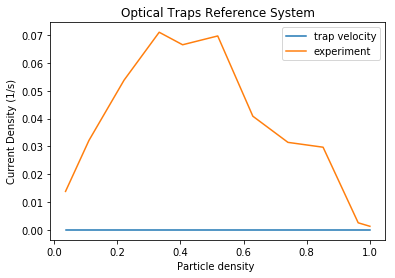

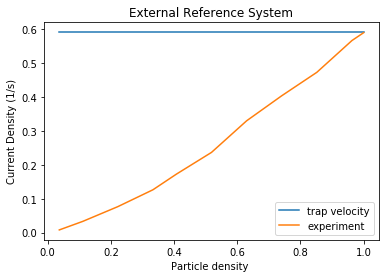

In [26]:
pdens_new = np.linspace(np.array(particleDens).min(),np.array(particleDens).max(),300)
#300 represents number of points to make between T.min and T.max

#spl = make_interp_spline(np.array(particleDens), np.array(co_currentDensity), k=3) #BSpline object, k = spline degree (3=cubic)
#co_currentDensity_smooth = spl(pdens_new)

#spl2 = make_interp_spline(np.array(particleDens), np.array(fix_currentDensity), k=3) #BSpline object, k = spline degree (3=cubic)
#fix_currentDensity_smooth = spl2(pdens_new)

co_trap_vel = 0*pdens_new 
fix_trap_vel = omega*pdens_new
trap_vel = np.zeros(len(pdens_new))
trap_vel[:] = omega

f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)
#ax1.plot(pdens_new,co_currentDensity_smooth, label='smooth')
ax1.plot(pdens_new,co_trap_vel, label='trap velocity')
ax1.plot(particleDens, co_currentDensity, label='experiment')
ax1.set_xlabel("Particle density ")
ax1.set_ylabel("Current Density (1/s)")
ax1.set_title("Optical Traps Reference System")
ax1.legend()
ax2 = f2.add_subplot(111)
#ax2.plot(pdens_new,fix_currentDensity_smooth, label='smooth')
ax2.plot(pdens_new, trap_vel, label='trap velocity')
ax2.plot(particleDens, fix_currentDensity, label='experiment')
ax2.set_xlabel("Particle density ")
ax2.set_ylabel("Current Density (1/s)")
ax2.set_title("External Reference System")
ax2.legend()
plt.show()

## Obtention of ASEP Current density

To calculate the current density of an ASEP process we need to know the mean velocity of a single particle in the same setup. This experiment was realized in Test 4 of the December 10th of 2018.

In [21]:
sFilepath, sTimeFP  = takeFileNames_SingleParticle3(sigma)

t_single = trackingLoading(sFilepath)
time_single = tmstmpLoading(sTimeFP)

particles = t_single['particle'].unique().tolist()

t_single = getPolarCoordinates(t_single)

co_velSingle = corotatingCurrentDensityObtainment(t_single, time_single, particles, 1/(2*np.pi*radius), omega, "vel")

fix_velSingle = fixedCurrentDensityObtainment(t_single, time_single, particles, 1/(2*np.pi*radius), omega, "vel") 
print("Mean Velocity Fixed Single Particle", fix_velSingle)
print("Mean Velocity Corrotating Single Particle", co_velSingle)

pd_ASEP = np.linspace(0, 1, 300)
co_cd_ASEP = co_velSingle*pd_ASEP*(1-pd_ASEP)
fix_cd_ASEP = fix_velSingle*pd_ASEP*(1-pd_ASEP)
co_currDens_0 = co_velSingle*pdens_new
fix_currDens_0 = fix_velSingle*pdens_new

Mean Velocity Fixed Single Particle 0.21619403145487895
Mean Velocity Corrotating Single Particle 0.3738059685451206


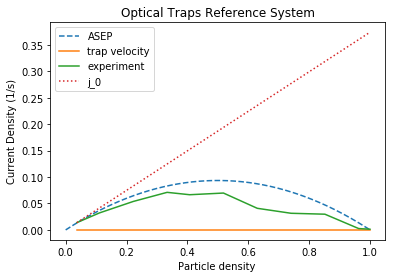

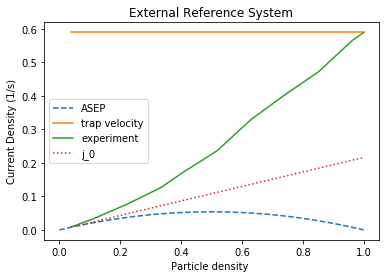

In [22]:
"""plt.plot(pd_ASEP, cd_ASEP, '--', label='ASEP')
plt.plot(pdens_new,currentDensity_smooth, label='smooth')
plt.plot(particleDens, currentDensity, label='experiment')
plt.plot(pdens_new, currDens_0, ':',label='j_0')
plt.xlabel("Particle density")
plt.ylabel("Current Density (1/s)")
plt.legend()
plt.show()"""

f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)
ax1.plot(pd_ASEP, co_cd_ASEP, '--', label='ASEP')
#ax1.plot(pdens_new,co_currentDensity_smooth, label='smooth')
ax1.plot(pdens_new,co_trap_vel, label='trap velocity')
ax1.plot(particleDens, co_currentDensity, label='experiment')
ax1.plot(pdens_new, co_currDens_0, ':',label='j_0')
ax1.set_xlabel("Particle density ")
ax1.set_ylabel("Current Density (1/s)")
ax1.set_title("Optical Traps Reference System")
ax1.legend()
ax2 = f2.add_subplot(111)
ax2.plot(pd_ASEP, fix_cd_ASEP, '--', label='ASEP')
#ax2.plot(pdens_new,fix_currentDensity_smooth, label='smooth')
ax2.plot(pdens_new, trap_vel, label='trap velocity')
ax2.plot(particleDens, fix_currentDensity, label='experiment')
ax2.plot(pdens_new, fix_currDens_0, ':',label='j_0')
#ax2.plot([0,1], [0,0], ':',color="k")
ax2.set_xlabel("Particle density ")
ax2.set_ylabel("Current Density (1/s)")
ax2.set_title("External Reference System")
ax2.legend()
plt.show()

TypeError: unsupported operand type(s) for /: 'list' and 'tuple'

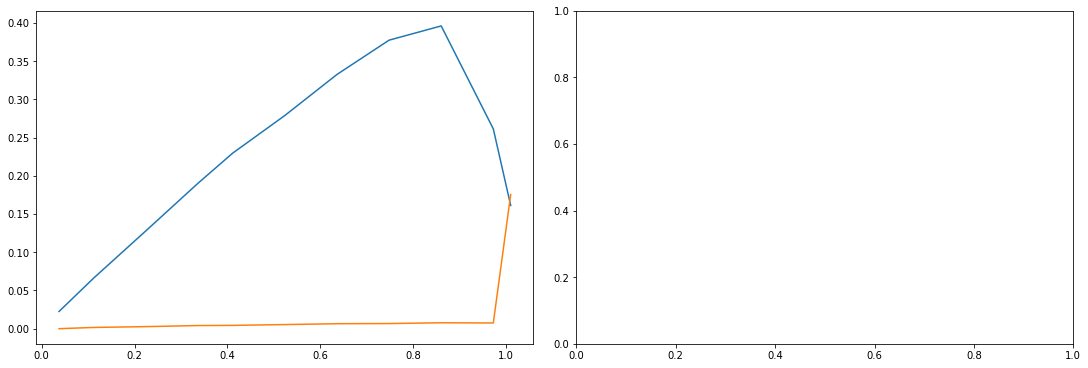

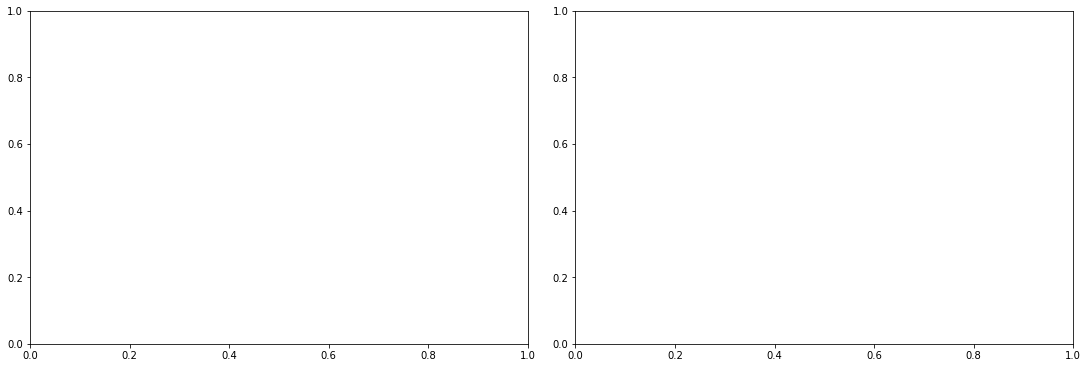

In [44]:
sigma = [0.98, 0.9, 0.8, 0.75, 0.62] #0.7, 0.6]#, 0.5]

f1, ax1 = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5))
f2, ax2 = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5))

for s in tqdm_notebook(sigma):
    
    newFilepath, timestampsFilepath = takeFileNames3(s)

    Nparticles = getNparticles3(s)

    wavlen = getWavelength(s)

    radius = getRadius(s)

    omega = getOmega(s)

    particleDens = Nparticles*wavlen/(2*np.pi*radius)
    co_currentDensity = []
    fix_currentDensity = []

    for i in np.linspace(0,len(newFilepath)-1, len(newFilepath), dtype=int):

        t = trackingLoading(newFilepath[i])
        time = tmstmpLoading(timestampsFilepath[i])

        particles = t['particle'].unique().tolist()

        t = getPolarCoordinates(t)
        co_currentDensity.append(corotatingCurrentDensityObtainment(t, time, particles, particleDens[i], omega))  
        fix_currentDensity.append(fixedCurrentDensityObtainment(t, time, particles, particleDens[i], omega))
        
    
    tag1 = "sigma = {}".format(s)

    ax1[0].plot(particleDens, co_currentDensity, label=tag1)
    ax1[1].plot(particleDens, co_currentDensity/co_currentDensity[0], label=tag1)
    
    ax2[0].plot(particleDens, fix_currentDensity, label=tag1)
    ax2[1].plot(particleDens, fix_currentDensity/fix_currentDensity[0], label=tag1)

co_velSingle = []

for s in tqdm_notebook(sigma):
    
    sFilepath, sTimeFP  = takeFileNames_SingleParticle3(s)
    t_single = trackingLoading(sFilepath)
    time_single = tmstmpLoading(sTimeFP)

    particles = t_single['particle'].unique().tolist()
    t_single = getPolarCoordinates(t_single)
    co_velSingle.append(corotatingCurrentDensityObtainment(t_single, time_single, particles, 1/(2*np.pi*radius), omega, "vel"))

pd_ASEP = np.linspace(0, 1, 300)
co_cd_ASEP = np.mean(co_velSingle)*pd_ASEP*(1-pd_ASEP)

ax1[0].plot(pd_ASEP, co_cd_ASEP, '--', label="j ASEP")
ax1[1].plot(pd_ASEP, co_cd_ASEP/co_currentDensity[0], '--', label="j ASEP")


ax1[0].set_xlabel("Particle density ")
ax1[0].set_ylabel("Current Density (1/s)")
ax1[0].set_title("No normalized")
ax1[0].legend()

ax1[1].set_xlabel("Particle density ")
#ax1[1].set_ylabel("Current Density (1/s)")
ax1[1].set_title("j0 Normalization")
ax1[1].legend()

ax2[0].set_xlabel("Particle density ")
ax2[0].set_ylabel("Current Density (1/s)")
ax2[0].legend()

ax2[1].set_xlabel("Particle density ")
#ax2[1].set_ylabel("Current Density (1/s)")
ax2[1].set_title("j0 Normalization")
ax2[1].legend()

f1.suptitle("Optical Traps Reference System")
f2.suptitle("External Reference System")
plt.show()

# BREAK, GOOD STUFF BELOW!

In [30]:
df = pd.DataFrame()

#Probar de introducir el punto de corriente de densidad de una partícula en la columna codens

sigma = [0.98, 0.9, 0.75, 0.62] #.8 [0.62] [0.98, 0.9, 0.85, 0.8, 0.75, 0.62] 
d = 4 #Particles' diameter

for s in tqdm_notebook(sigma):
    
    trackFilepaths, tmsFilepaths = takeFileNames3(s)

    sTrackFilepath, sTmstmpFilepath = takeFileNames_SingleParticle3(s)

    Nparticles = getNparticles3(s)
    wavlen = getWavelength(s)
    radius = getRadius(s)
    omega = getOmega(s)

    particleDens = np.around(Nparticles*d/(2*np.pi*radius), 2)
    
    #tracking obtantion of single particle
    t_single = trackingLoading(sTrackFilepath)
    tmtmp_single = tmstmpLoading(sTmstmpFilepath)

    #number of paricles for the single files
    single_particles = t_single['particle'].unique().tolist()

    #Obtainment of polar coordinates 
    t_single = getPolarCoordinates(t_single)

    #Obtainment of velocity and current density for single particles
    sing_codens, scerr = corotatingCurrentDensityObtainment(t_single, tmtmp_single, single_particles, d/(2*np.pi*radius), omega)
    #sing_fixdens, sferr = fixedCurrentDensityObtainment(t_single, tmtmp_single, single_particles, wavlen/(2*np.pi*radius), omega)
    co_vel, sing_velerr = corotatingCurrentDensityObtainment(t_single, tmtmp_single, single_particles, d/(2*np.pi*radius), omega, "vel")
    #fix_vel = fixedCurrentDensityObtainment(t_single, tmtmp_single, single_particles, wavlen/(2*np.pi*radius), omega, "vel")


    for j in np.linspace(0, len(trackFilepaths)-1, len(trackFilepaths), dtype=int):

#        newFilepath = trackFilepaths
#        newTimeFilepath = tmsFilepaths
#        
#        if newFilepath != []:

#            t = trackingLoading(newFilepath[j]) 
#            time = tmstmpLoading(newTimeFilepath[j])

#            particles = t['particle'].unique().tolist()

#            t = getPolarCoordinates(t)

#            codens, co_error = corotatingCurrentDensityObtainment(t, time, particles, particleDens[j], omega)
#            mean_vel, velerr = corotatingCurrentDensityObtainment(t, time, particles, particleDens[j], omega, "vel")
            #fixdens, fix_error = fixedCurrentDensityObtainment(t, time, particles, particleDens[j], omega)
            
#            split_file = newFilepath[j].split('_')
#            reconstruct_file = split_file[1]+"_"+split_file[2].split('.')[0]
            
#            df = df.append({'sigma': s, 'test': j, 'p_density': particleDens[j],'codens': codens,
#                            'sing_codens': sing_codens, 'co_vel': co_vel, 'mean_vel': mean_vel, 'vel_error': velerr,
#                            'radius': radius, 'omega': omega, 'lambda': wavlen, 'N particles': Nparticles[j],
#                            'File Name':reconstruct_file, 'error': co_error}, ignore_index=True)


#df.test = df.test.astype(int)
#df = df.set_index(['sigma', 'test', 'p_density'], drop=True)

#df['norm_codens'] = np.NaN
#df['norm_fixdens'] =  np.NaN

#for s, pr in df.groupby('sigma'):

#    for t, p in df.groupby('test'):
#        df.loc[idx[s, t, :], 'norm_codens'] = df.loc[idx[s, t, :], 'codens'].values/ df.loc[idx[s, t, :], 'co_vel'].values #sing_codens
#        df.loc[idx[s, t, :], 'norm_coerror'] = df.loc[idx[s, t, :], 'error'].values/ df.loc[idx[s, t, :], 'co_vel'].values #sing_codens
        #df.loc[idx[s, t, :], 'norm_fixdens'] = df.loc[idx[s, t, :], 'fixdens'].values/ df.loc[idx[s, t, :], 'sing_fixdens'].values
        #df.loc[idx[s, t, :], 'norm_fixerror'] = df.loc[idx[s, t, :], 'fix_error'].values/ df.loc[idx[s, t, :], 'sing_fixdens'].values

            df = df.append({'Particle_size': s, 'Particle_density': particleDens[j], 'Current_density': codens,
                            'Single_particle_current_density': sing_codens,
                            'Single_particle_velocity': co_vel, 'mean_velocity': mean_vel,
                            'Mean_velocity_error': velerr,
                            'Radius': radius, 'Potential_landscape_velocity': omega,
                            'Potential_landscape_wavelength': wavlen, 'Number_of_particles': Nparticles[j],
                            'Current_density_error': co_error, 'test': j}, ignore_index=True)
#'test': j, 'File Name':reconstruct_file,

df.test = df.test.astype(int)
df = df.set_index(['Particle_size', 'test', 'Particle_density'], drop=True)

df['norm_codens'] = np.NaN

for s, pr in df.groupby('Particle_size'):

    for t, p in df.groupby('test'):
        df.loc[idx[s, t, :], 'Normalized_current_density'] = df.loc[idx[s, t, :], 'Current_density'].values/ df.loc[idx[s, t, :], 'Single_particle_velocity'].values #sing_codens
        df.loc[idx[s, t, :], 'Normalized_current_density_error'] = df.loc[idx[s, t, :], 'Current_density_error'].values/ df.loc[idx[s, t, :], 'Single_particle_velocity'].values

df

Current_density  Current_density_error  \
Particle_size test Particle_density                                           
0.98          0    0.04                     0.395219                0.00157   
              1    0.11                     0.395219                0.00157   
              2    0.22                     0.395219                0.00157   
              3    0.33                     0.395219                0.00157   
              4    0.40                     0.395219                0.00157   
              5    0.51                     0.395219                0.00157   
              6    0.62                     0.395219                0.00157   
              7    0.73                     0.395219                0.00157   
              8    0.84                     0.395219                0.00157   
              9    0.95                     0.395219                0.00157   
              10   0.98                     0.395219                0.00157   
0.90          0    0.03                     0.395219                0.00157   
              1    0.10                     0.395219                0.00157   
              2    0.20                     0.395219                0.00157   
              3    0.30                     0.395219                0.00157   
              4    0.37                     0.395219                0.00157   
              5    0.47                     0.395219                0.00157   
              6    0.57                     0.395219                0.00157   
              7    0.67                     0.395219                0.00157   
              8    0.77                     0.395219                0.00157   
              9    0.87                     0.395219                0.00157   
              10   0.90                     0.395219                0.00157   
0.75          0    0.03                     0.395219                0.00157   
              1    0.08                     0.395219                0.00157   
              2    0.17                     0.395219                0.00157   
              3    0.25                     0.395219                0.00157   
              4    0.31                     0.395219                0.00157   
              5    0.39                     0.395219                0.00157   
              6    0.47                     0.395219                0.00157   
              7    0.56                     0.395219                0.00157   
              8    0.64                     0.395219                0.00157   
              9    0.73                     0.395219                0.00157   
0.62          0    0.02                     0.395219                0.00157   
              1    0.07                     0.395219                0.00157   
              2    0.14                     0.395219                0.00157   
              3    0.21                     0.395219                0.00157   
              4    0.26                     0.395219                0.00157   
              5    0.32                     0.395219                0.00157   
              6    0.39                     0.395219                0.00157   
              7    0.46                     0.395219                0.00157   
              8    0.53                     0.395219                0.00157   
              9    0.60                     0.395219                0.00157   

                                     Mean_velocity_error  Number_of_particles  \
Particle_size test Particle_density                                             
0.98          0    0.04                         0.001689                  1.0   
              1    0.11                         0.001689                  3.0   
              2    0.22                         0.001689                  6.0   
              3    0.33                         0.001689                  9.0   
              4    0.40                         0.001689                 1

In [31]:
df.reset_index(inplace=True)
del df['test']
df = df.filter(["Number_of_particles", "mean_velocity", "Particle_size", "Radius", "Potential_landscape_velocity"])
df

,Number_of_particles,mean_velocity,Particle_size,Radius,Potential_landscape_velocity
0,1.0,0.424966,0.98,17.488,0.72
1,3.0,0.424966,0.98,17.488,0.72
2,6.0,0.424966,0.98,17.488,0.72
3,9.0,0.424966,0.98,17.488,0.72
4,11.0,0.424966,0.98,17.488,0.72
5,14.0,0.424966,0.98,17.488,0.72
6,17.0,0.424966,0.98,17.488,0.72
7,20.0,0.424966,0.98,17.488,0.72
8,23.0,0.424966,0.98,17.488,0.72
9,26.0,0.424966,0.98,17.488,0.72


In [32]:
#Save to .csv file
df.to_csv("C:/Users/Eric/Desktop/U0_Not_Constant_Dataset.dat", sep = "\t")

# Current density vs. ro

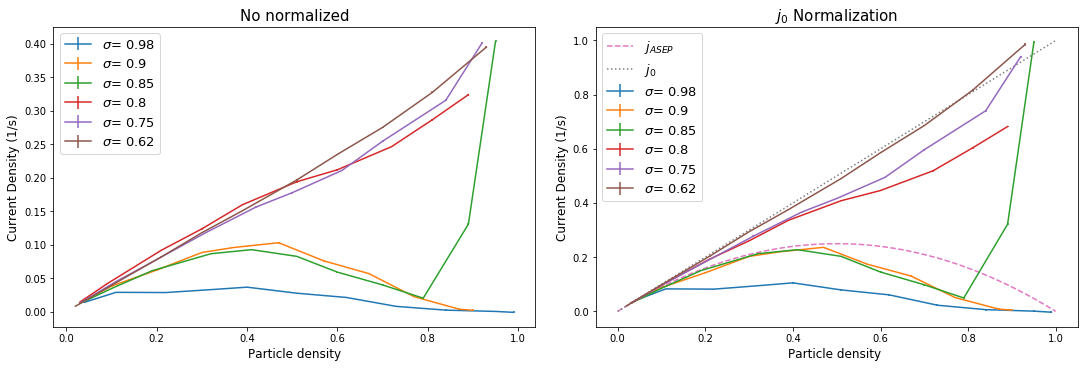

In [59]:
f1, ax1 = plt.subplots(1,2,constrained_layout=True,figsize=(15,5))#plt.subplots(1,1,constrained_layout=True,figsize=(10,7.5)) #
#f2, ax2 = plt.subplots(1,2,constrained_layout=True,figsize=(15,5))

for s in sigma:
    
    tag1 = "$\sigma$= {}".format(s)

    x = df.loc[idx[s, :, :], :].index.get_level_values("p_density").unique()

    #ax1[0].plot(x, df.loc[idx[s, :, :], 'codens'], label=tag1)
    #ax1[1].plot(x, df.loc[idx[s, :, :], 'norm_codens'], label=tag1)
    
    ax1[0].errorbar(x, df.loc[idx[s, :, :], 'codens'], df.loc[idx[s, :, :], 'error'], label=tag1)
    ax1[1].errorbar(x, df.loc[idx[s, :, :], 'norm_codens'], df.loc[idx[s, :, :], 'norm_coerror'], label=tag1)

    #ax2[0].plot(x, df.loc[idx[s, :, :], 'fixdens'], label=tag1)
    #ax2[1].plot(x, df.loc[idx[s, :, :], 'norm_fixdens'], label=tag1)
    
    #ax2[0].errorbar(x, df.loc[idx[s, :, :], 'fixdens'], df.loc[idx[s, :, :], 'fix_error'], label=tag1)
    #ax2[1].errorbar(x, df.loc[idx[s, :, :], 'norm_fixdens'], df.loc[idx[s, :, :], 'norm_fixerror'], label=tag1)


#ax1[0].plot(pd_ASEP, co_cd_ASEP, '--', label="j ASEP")

pd_ASEP = np.linspace(0, 1, 300)
co_velSingle = df.loc[idx[:, :, :], 'co_vel'].mean()
mean_ASEP = co_velSingle*pd_ASEP*(1-pd_ASEP)

ax1[1].plot(pd_ASEP, mean_ASEP/df.loc[idx[:, :, :], 'co_vel'].mean(), '--', label="$j_{ASEP}$")#sing_codens

co_currDens_0 = co_velSingle*pd_ASEP/df.loc[idx[:, :, :], 'co_vel'].mean()#sing_codens
ax1[1].plot(pd_ASEP, co_currDens_0, ':',label='$j_0$')

ax1[0].set_xlabel("Particle density", fontfamily="sans-serif",  fontsize=12)
ax1[0].set_ylabel("Current Density (1/s)", fontfamily="sans-serif",  fontsize=12)
ax1[0].set_title("No normalized", fontfamily="sans-serif",  fontsize=15)
ax1[0].legend(fontsize=13)
#ax1[1].legend(fontsize=13)

#ax1.set_ylim(0,30)

#ax1.set_xticklabels(np.linspace(0, 1, 4), rotation=0, fontsize=15)
#ax1.set_yticklabels(np.linspace(0, 30, 7), rotation=0, fontsize=15);

ax1[1].set_xlabel("Particle density ", fontfamily="sans-serif",  fontsize=12)
ax1[1].set_ylabel("Current Density (1/s)", fontfamily="sans-serif",  fontsize=12)
ax1[1].set_title("$j_0$ Normalization", fontfamily="sans-serif",  fontsize=15)
ax1[1].legend(fontsize=13)

#ax2[0].set_xlabel("Particle density ")
#ax2[0].set_ylabel("Current Density (1/s)")
#ax2[0].legend()

#ax2[1].set_xlabel("Particle density ")
#ax2[1].set_ylabel("Current Density (1/s)")
#ax2[1].set_title("j0 Normalization")
#ax2[1].legend()

#f1.suptitle("Optical Traps Reference System")
#f2.suptitle("External Reference System")
plt.show()

# Current density vs. sigma

In [25]:
df.loc[idx[:, :, 0.04], :].index.get_level_values("sigma").unique()

Float64Index([0.98, 0.9, 0.8, 0.75, 0.62], dtype='float64', name='sigma')

C:\Users\Eric\Anaconda3\lib\site-packages\matplotlib\_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '


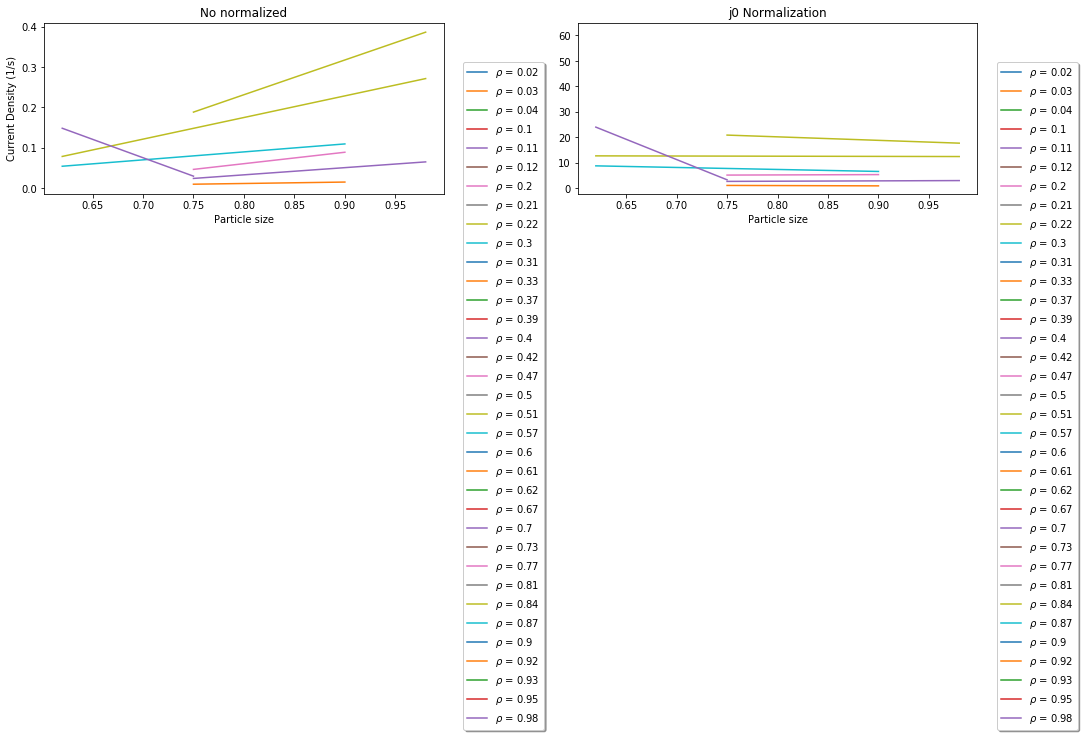

In [20]:
f, ax = plt.subplots(1,2,constrained_layout=True,figsize=(15,7.5))

for dens, trj_sub in df.groupby("p_density"):
    
    tag1 = r"$\rho$ = {}".format(dens)

    x = df.loc[idx[:, :, dens], :].index.get_level_values("sigma").unique()

    ax[0].plot(x, df.loc[idx[:, :, dens], 'codens'], label=tag1)
    ax[1].plot(x, df.loc[idx[:, :, dens], 'norm_codens'], label=tag1)
    
ax[0].set_xlabel("Particle size")
ax[0].set_ylabel("Current Density (1/s)")
ax[0].set_title("No normalized")
ax[0].legend()

ax[1].set_xlabel("Particle size")
#ax1[1].set_ylabel("Current Density (1/s)")
ax[1].set_title("j0 Normalization")
ax[1].legend()

ax[0].legend(loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)
ax[1].legend(loc='upper center', bbox_to_anchor=(1.15, 0.8), shadow=True, ncol=1)

In [ ]:
"""#Fitting linear regression 
range1 = np.where(pdens_new<0.6)
range2 = np.where(pdens_new>0.8)
lin_fit1 = np.polyfit(np.array(currentDensity_smooth)[range1], pdens_new[range1], 1)
lin_fit2 = np.polyfit(np.array(currentDensity_smooth)[range2], pdens_new[range2], 1)

fit1 = np.polyval(lin_fit1, pdens_new)
fit2 = np.polyval(lin_fit2, pdens_new)
print("Fit range 1 params: Solpe = ", lin_fit1[0], "Ind term = ", lin_fit1[1])
print("Fit range 2 params: Solpe = ", lin_fit2[0], "Ind term = ", lin_fit2[1])

plt.plot(pdens_new,currentDensity_smooth, label='smooth')
plt.plot(pdens_new[range1], fit1[range1], '--', label='fit1')
plt.plot(pdens_new[range2], fit2[range2], ':', label='fit2')
plt.xlabel("Particle density (1/um)")
plt.ylabel("Current Density (1/s)")
plt.legend()"""